In [1]:
# %matplotlib inline
# %matplotlib notebook
from dataGen import Gen
from multiscale_vae import vae
from train import slidingWindow, criterion, train, test

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.distributions


import numpy as np
import matplotlib.pyplot as plt
import pprint

In [2]:
# all parameters for generating the time series should be configured in this cell
periode = 30 #days
step = 5 # mess interval in minutes
val = 100
n_channels = 3
effects = {
    "Pulse": {
        "occurances":0,
        "max_amplitude":2,   
        "interval":20
        },
    "Trend": {
        "occurances":1,
        "max_slope":0.005,
        "type":"mixed"
        },
    "Seasonality": {
        "occurances":2,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

### Init Model
latent_dims = 15
L = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

v = vae(n_channels, L, latent_dims)
opt = optim.Adam(v.parameters(), lr = 0.001)

{'cov': array([[[1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32),
 'mu': array([[11.974664, 12.122421, 12.265839, ..., 12.855634, 12.734275,
        12.607723],
       [25.431583, 25.220161, 25.003624, ..., 46.32352 , 46.578285,
        46.828445],
       [64.      , 64.      , 64.      , ..., 64.      , 64.      ,
        64.      ]], dtype=float32),
 'n': 8640,
 'nchannels': 3}
{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [], 'channel': [], 'index': []},
 'Seasonality': {'amplitude': [14, 5],
                 'channel': [1, 0],
                 'frequency_per_week': [7.176202098924219, 1

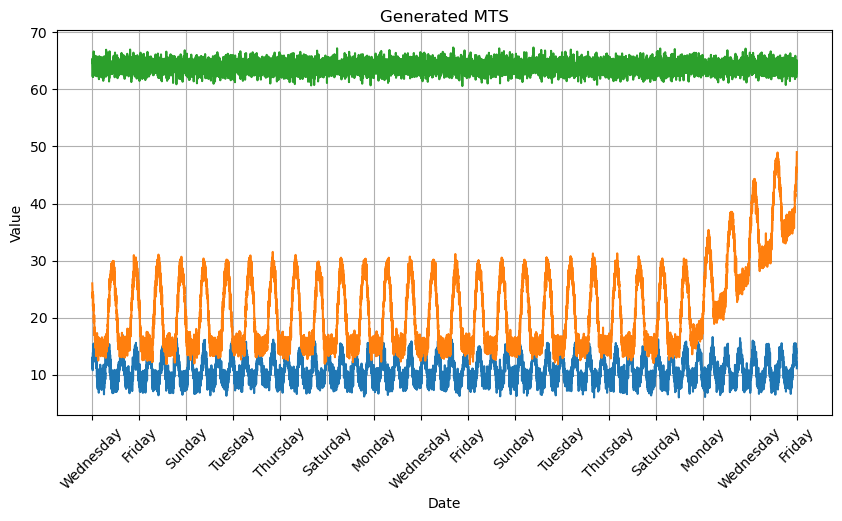

In [3]:
X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
pprint.pprint(params)
pprint.pprint(e_params)
X.show()

In [13]:
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

# train_set = slidingWindow(train, 30)
# val_set = slidingWindow(val, 30)
# test_set = slidingWindow(test, 30)

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size=10,
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=10,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=10,
                        shuffle = False
                        )

In [14]:
for epoch in range(1, 100):
    train(v, train_data, criterion, opt, device, epoch)

Train Epoch: 1 [0/3426 (0%)]	Loss: 6562.343750
Train Epoch: 1 [1000/3426 (29%)]	Loss: 6230.293359
Train Epoch: 1 [2000/3426 (58%)]	Loss: 5782.753125
Train Epoch: 1 [3000/3426 (87%)]	Loss: 3291.083984
====> Epoch: 1 Average loss: 5276.3488
Train Epoch: 2 [0/3426 (0%)]	Loss: 4922.356641
Train Epoch: 2 [1000/3426 (29%)]	Loss: 3960.427734
Train Epoch: 2 [2000/3426 (58%)]	Loss: 3094.571484
Train Epoch: 2 [3000/3426 (87%)]	Loss: 1176.598535
====> Epoch: 2 Average loss: 3021.7935
Train Epoch: 3 [0/3426 (0%)]	Loss: 2262.439063
Train Epoch: 3 [1000/3426 (29%)]	Loss: 1601.615039
Train Epoch: 3 [2000/3426 (58%)]	Loss: 1063.643555
Train Epoch: 3 [3000/3426 (87%)]	Loss: 239.662329
====> Epoch: 3 Average loss: 1127.6354
Train Epoch: 4 [0/3426 (0%)]	Loss: 733.565820
Train Epoch: 4 [1000/3426 (29%)]	Loss: 450.848437
Train Epoch: 4 [2000/3426 (58%)]	Loss: 252.188428
Train Epoch: 4 [3000/3426 (87%)]	Loss: 163.018298
====> Epoch: 4 Average loss: 327.6021
Train Epoch: 5 [0/3426 (0%)]	Loss: 610.755225
Trai

====> Epoch: 35 Average loss: 126.4315
Train Epoch: 36 [0/3426 (0%)]	Loss: 141.333643
Train Epoch: 36 [1000/3426 (29%)]	Loss: 68.290570
Train Epoch: 36 [2000/3426 (58%)]	Loss: 31.974991
Train Epoch: 36 [3000/3426 (87%)]	Loss: 290.651074
====> Epoch: 36 Average loss: 126.3877
Train Epoch: 37 [0/3426 (0%)]	Loss: 150.097290
Train Epoch: 37 [1000/3426 (29%)]	Loss: 68.030743
Train Epoch: 37 [2000/3426 (58%)]	Loss: 31.775961
Train Epoch: 37 [3000/3426 (87%)]	Loss: 290.789624
====> Epoch: 37 Average loss: 126.7274
Train Epoch: 38 [0/3426 (0%)]	Loss: 140.010974
Train Epoch: 38 [1000/3426 (29%)]	Loss: 68.420190
Train Epoch: 38 [2000/3426 (58%)]	Loss: 31.925449
Train Epoch: 38 [3000/3426 (87%)]	Loss: 290.778564
====> Epoch: 38 Average loss: 126.4101
Train Epoch: 39 [0/3426 (0%)]	Loss: 141.775671
Train Epoch: 39 [1000/3426 (29%)]	Loss: 68.095673
Train Epoch: 39 [2000/3426 (58%)]	Loss: 31.861731
Train Epoch: 39 [3000/3426 (87%)]	Loss: 290.764868
====> Epoch: 39 Average loss: 126.5534
Train Epoch: 

Train Epoch: 70 [2000/3426 (58%)]	Loss: 31.506216
Train Epoch: 70 [3000/3426 (87%)]	Loss: 290.438159
====> Epoch: 70 Average loss: 126.4348
Train Epoch: 71 [0/3426 (0%)]	Loss: 141.312134
Train Epoch: 71 [1000/3426 (29%)]	Loss: 67.997406
Train Epoch: 71 [2000/3426 (58%)]	Loss: 31.758331
Train Epoch: 71 [3000/3426 (87%)]	Loss: 290.162012
====> Epoch: 71 Average loss: 126.2525
Train Epoch: 72 [0/3426 (0%)]	Loss: 141.989661
Train Epoch: 72 [1000/3426 (29%)]	Loss: 67.705573
Train Epoch: 72 [2000/3426 (58%)]	Loss: 32.240018
Train Epoch: 72 [3000/3426 (87%)]	Loss: 289.108081
====> Epoch: 72 Average loss: 126.1556
Train Epoch: 73 [0/3426 (0%)]	Loss: 148.736206
Train Epoch: 73 [1000/3426 (29%)]	Loss: 68.052704
Train Epoch: 73 [2000/3426 (58%)]	Loss: 31.497284
Train Epoch: 73 [3000/3426 (87%)]	Loss: 290.334717
====> Epoch: 73 Average loss: 126.5599
Train Epoch: 74 [0/3426 (0%)]	Loss: 151.967444
Train Epoch: 74 [1000/3426 (29%)]	Loss: 67.642291
Train Epoch: 74 [2000/3426 (58%)]	Loss: 23.767505
Tr

In [6]:
def compare(dataset, model):
    model.eval()
    rec = []
    x = []
    with torch.no_grad():
        for i, data in enumerate(dataset):
            x_rec, mu, logvar = model(data)
            z = v.reparametrization_trick(mu, logvar)

            x.extend(data[:,:,0].detach().numpy())
            rec.extend(x_rec[:].detach().numpy())
        
    print(mu[-1, :], logvar[-1, :])
    plt.plot(rec, "r--")
    plt.plot(x[:], "b-")
    plt.ylim(0,100)
    plt.grid(True)
    
    return z[-1, :]

tensor([-0.7955, -2.2696, -1.8923,  3.6475,  1.4718, -0.4319, -1.2467,  0.1501,
        -0.3561, -1.2846,  0.9680, -3.5318, -2.5715,  0.3382,  1.7060, -4.2711,
         1.6263,  0.6539, -0.2554, -2.3130, -0.6451,  1.2736, -2.4923,  3.1784,
        -1.9442,  1.7983, -2.6682, -4.0313, -1.2649,  1.2168]) tensor([ 1.5133, -0.5652,  1.5637, -0.4608,  1.4404, -1.0599,  0.5396,  1.9588,
        -0.7858, -2.2376,  1.8896, -1.5470,  2.8560, -1.2120, -0.5109, -3.2821,
        -0.3790, -2.3151, -3.2752,  1.7679,  1.6468, -2.7248, -0.4014, -2.5070,
        -2.7399,  3.6985,  0.8119, -1.4421, -0.5737, -0.5366])


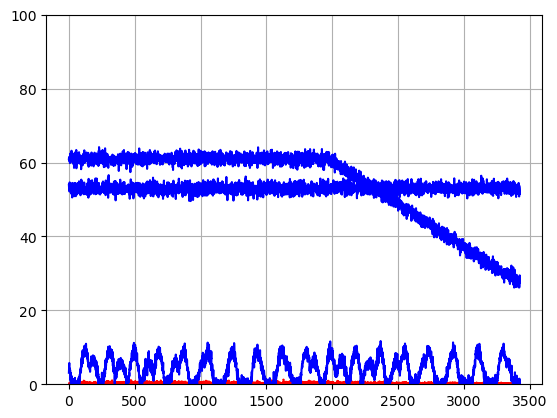

In [16]:
z = compare(train_data, v)

tensor([-0.0288,  0.0423,  0.0870,  0.1189,  0.0225, -0.1058,  0.0380,  0.0802,
        -0.0765, -0.1252,  0.0516, -0.0678,  0.0622,  0.0663,  0.0748,  0.0238,
        -0.2280,  0.0101,  0.2048,  0.0450, -0.1267, -0.1288,  0.1584,  0.0196,
        -0.0903, -0.1603,  0.0188, -4.2320,  0.0732,  0.1064, -0.3037, -0.0069,
        -0.2792,  0.0974, -0.5472, -0.2787, -0.6384, -0.2760, -0.4602, -0.1374,
         0.2329,  0.2540,  0.4154,  0.2631,  0.2781, -0.2412, -0.1498, -0.4592,
         0.3101, -0.1094,  0.4056,  0.4509, -0.0753, -0.6435,  0.1200,  0.4528,
        -0.1529, -0.0251, -0.4383,  0.1328]) tensor([-7.8705e-03, -6.6738e-02, -1.0920e-01,  5.9775e-02,  1.4927e-02,
        -6.7581e-02,  4.2559e-02, -8.0438e-03, -1.6947e-01, -1.0789e-02,
        -1.0851e-01,  6.1943e-02, -7.4103e-02, -3.3179e-02,  4.1320e-04,
         3.9609e-03,  2.2657e-01,  3.0639e-02, -2.2359e-04,  3.3089e-02,
        -1.3404e-01, -8.1576e-02, -6.7540e-02,  2.7328e-02, -4.0493e-02,
        -1.0502e-01, -1.7374e-

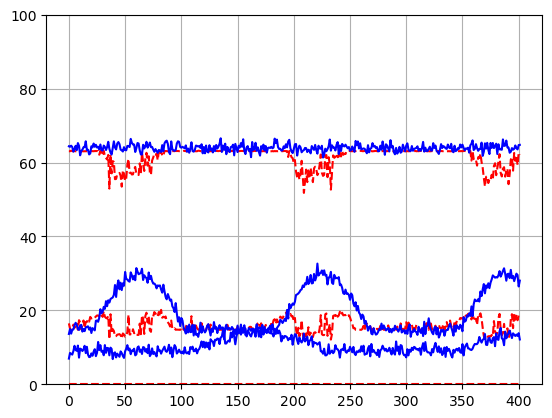

In [8]:
z = compare(test_data, v)

In [9]:
test(v, test_data, criterion, device)

====> Test set loss: 40.7919


1000


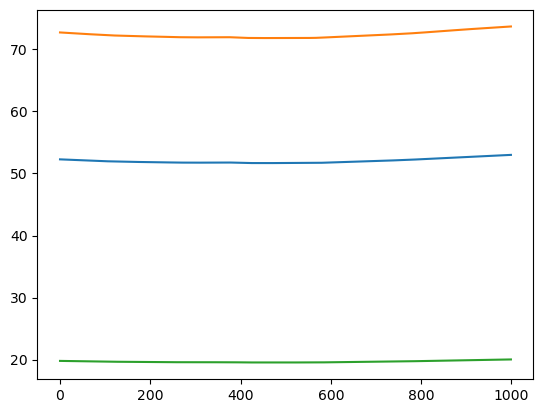

In [36]:
rec = []
for i in range(1000):
    z[16] = 0.01*i
    
    x_rec = v.decoder(z)

    rec.append(x_rec.detach().numpy())
print(len(rec))
plt.plot(rec)

In [37]:
z = np.arange(0.001,1, 0.01)
z

array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991])

In [40]:
# %matplotlib 
# import ipywidgets as widgets

# z = np.arange(16)
# @interact(z, np.arange(0.001,10, 0.01))
def experiment(z,z_num):
    rec = []
    for i in range(1000):
        z[z_num] = 0.01*i

        x_rec = v.decoder(z)

        rec.append(x_rec.detach().numpy())
    print(len(rec))
    plt.plot(rec)
    
# widgets.interact(experiment, z)

1000


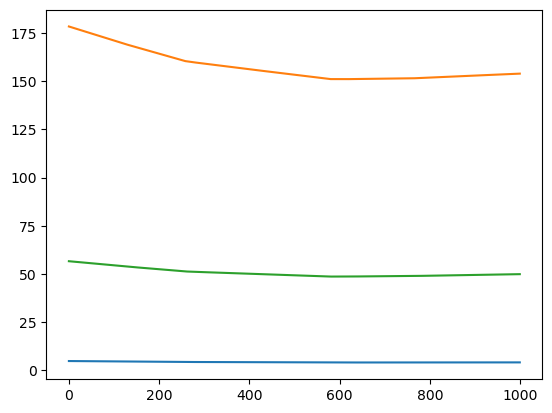

In [64]:
experiment(z,3)

In [ ]:
1) Pulse/ Rechteck
2) Trends (linear or not)
3) Periodicity
std. effects
5) coupling durch cov matrix
6) Noise
7) Effect of latent dim änderung, welche größe ist am besten  geeignet, soll latent_dim = n_channels sein? couploung durch hiarchie?
Modeling of interactions effects in die simulation hilft um die interpretation zu validieren, man kann die effecte aus der realen daten 
besser mathematisch verstehen
8) Short and long term effects durch die verschiedenen Convolutions weights"aktivierung von neuronen/ welche neuraonen sind mehr active in welche fälle"
idee is to know what layers capt long term effects and which layers capt short terms to be able to better interpret the data
9) also change the effects to be intern effects -> they happen on the level of mean and std rather than additif to the channels and let only be some random noise additif (y = x +epsilon)
all the rest (trends, seasonalities, pulses should happen on the level of mean and std)


Write and document all the steps I wanna do and make check list
try to make the data scales and dimention real (x axes represents tims -> days, hours, secs / are the seasonalities daily or weekly etc)

In [4]:
60/5

12.0

In [5]:
12*24

288

In [6]:
288*7

2016

In [7]:
2016*4

8064

In [8]:
60*24

1440

In [4]:
array = np.random.randint(10, size=(5,5))

In [5]:
array

array([[1, 8, 4, 1, 3],
       [6, 5, 3, 9, 6],
       [9, 1, 9, 4, 2],
       [6, 7, 8, 8, 9],
       [2, 0, 6, 7, 8]])

In [16]:
channels = [2,4]
start_idx = [1,2]
end_idx = [4,4]
[array[channels[i],start_idx[i]:end_idx[i]] for i in range(len(channels))]
# array[channels[,]start_idx]

[array([1, 9, 4]), array([6, 7])]

In [10]:
720/24

30.0

In [11]:
24*12*2


576